# Auto Feature Selection
- What model combinations can be used to find the ideal features to model a time series with and also to make the best forecasts?  
- See [Auto Model Specification with ML Techniques for Time Series](https://towardsdatascience.com/auto-model-specification-with-ml-techniques-for-time-series-e7b9a90ae9d7)  

In [2]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.util import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

Diagram to demonstrate the [auto_Xvar_select()](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.auto_Xvar_select) method:


![](./diagram.jpg)

## Use 50 Random Series from M4 Hourly

In [3]:
models = (
    'mlr',
    'elasticnet',
    'gbt',
    'knn',
    'svr',
    'mlp',
)

Hourly = pd.read_csv(
    r'C:\Users\jinlei\Documents\2023\mikekeith52\data\Hourly-train.csv',
    index_col=0,
).sample(50)

Hourly_test = pd.read_csv(
    r'C:\Users\jinlei\Documents\2023\mikekeith52\data\Hourly-test.csv',
    index_col=0,
)
Hourly_test = Hourly_test.loc[Hourly.index]

info = pd.read_csv(
    r'C:\Users\jinlei\Documents\2023\mikekeith52\data\M4-info.csv',
    index_col=0,
    parse_dates=['StartingDate'],
    dayfirst=True,
)

results = pd.DataFrame(
    index = models,
    columns = models,
).fillna(0)

## Run all Model Combos and Evaluate SMAPE

In [5]:
for i in tqdm(Hourly.index):
    y = Hourly.loc[i].dropna()
    sd = info.loc[i,'StartingDate']
    fcst_horizon = info.loc[i,'Horizon']
    cd = pd.date_range(
        start = sd,
        freq = 'H',
        periods = len(y),
    )
    f = Forecaster(
        y = y,
        current_dates = cd,
        future_dates = fcst_horizon,
        test_length = fcst_horizon, # for finding xvars
    )
    # extension of this analysis - take transformations
    for xvm in models:
        for fcstm in models:
            f2 = f.deepcopy()
            f2.auto_Xvar_select(
                estimator = xvm,
                monitor='TestSetRMSE',
                max_ar = 48,
                exclude_seasonalities = ['quarter','month','week','day'],
            )
            f2.set_estimator(fcstm)
            f2.manual_forecast(dynamic_testing=False)
            point_fcst = f2.export('lvl_fcsts')[fcstm]
            results.loc[xvm,fcstm] += metrics.smape(
                Hourly_test.loc[i].dropna().values,
                point_fcst.values,
            )

  0%|          | 0/50 [00:00<?, ?it/s]

## View Results

### SMAPE Combos

In [6]:
results = results / 50
results

,mlr,elasticnet,gbt,knn,svr,mlp
mlr,0.175789,0.306184,0.141702,0.130137,0.228169,0.743317
elasticnet,0.187225,0.274259,0.127963,0.120628,0.231848,0.608529
gbt,0.189571,0.324034,0.128174,0.146242,0.233158,0.821538
knn,0.217871,0.329362,0.169831,0.120976,0.241280,0.791132
svr,0.179982,0.321648,0.128591,0.144956,0.200857,0.816428
mlp,0.179795,0.292953,0.136988,0.119620,0.236302,0.582204


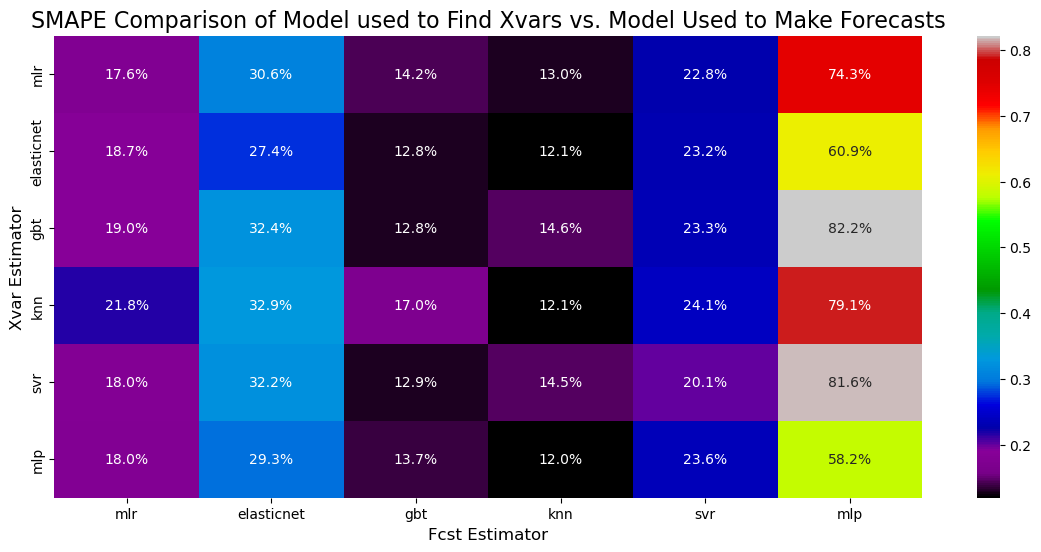

In [7]:
fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(results,cmap='nipy_spectral',ax=ax,annot=True,fmt='.1%')
plt.ylabel('Xvar Estimator',size=12)
plt.xlabel('Fcst Estimator',size=12)
plt.title('SMAPE Comparison of Model used to Find Xvars vs. Model Used to Make Forecasts',size=16)
plt.show()

### Best Models at Making Forecasts on Average

In [8]:
# Fcst estimators
results.mean().sort_values()

knn           0.130427
gbt           0.138875
mlr           0.188372
svr           0.228602
elasticnet    0.308074
mlp           0.727191
dtype: float64

### Best Models at Finding Xvars on Average

In [9]:
# Xvar estimators
results.mean(axis=1).sort_values()

mlp           0.257977
elasticnet    0.258409
mlr           0.287550
svr           0.298744
gbt           0.307120
knn           0.311742
dtype: float64

In [10]:
results

,mlr,elasticnet,gbt,knn,svr,mlp
mlr,0.175789,0.306184,0.141702,0.130137,0.228169,0.743317
elasticnet,0.187225,0.274259,0.127963,0.120628,0.231848,0.608529
gbt,0.189571,0.324034,0.128174,0.146242,0.233158,0.821538
knn,0.217871,0.329362,0.169831,0.120976,0.241280,0.791132
svr,0.179982,0.321648,0.128591,0.144956,0.200857,0.816428
mlp,0.179795,0.292953,0.136988,0.119620,0.236302,0.582204


In [11]:
models

('mlr', 'elasticnet', 'gbt', 'knn', 'svr', 'mlp')